In [62]:
import torch

In [72]:
# create a 4 layer MLP network
class MLP(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64, num_layers=4):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(input_size, hidden_size))
        for _ in range(num_layers - 2):
            self.layers.append(torch.nn.Linear(hidden_size, hidden_size))
        self.layers.append(torch.nn.Linear(hidden_size, output_size))

    def forward(self, x):
        for i in range(self.num_layers - 1):
            x = torch.nn.functional.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x

In [73]:
# function y = x1/(x2+0.5)
def fn(x1, x2):
    return x1/(x2+0.5)

In [78]:
# generate training data
def generate_data(num_data):
    x = torch.rand((num_data, 2), device='cuda')
    y = fn(x[:,0], x[:,1])
    return x, y
num_data = 1000
x, y = generate_data(num_data)

In [85]:
# train network
model = MLP(2, 1, 256, 3).to('cuda')
# compressor_y = MLP(1,1,256,3).to('cuda')
compressor_y = lambda x: x
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
batch_size = 64
num_epochs = 4
loss_list = []
for epoch in range(num_epochs):
    for i in range(num_data//batch_size):
        x_batch = x[i*batch_size:(i+1)*batch_size, :]
        y_batch = y[i*batch_size:(i+1)*batch_size]
        y_pred = model(x_batch)
        y_batch_compressed = compressor_y(y_batch.unsqueeze(-1))
        loss = criterion(y_pred, y_batch_compressed)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    if epoch % 5 == 4:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

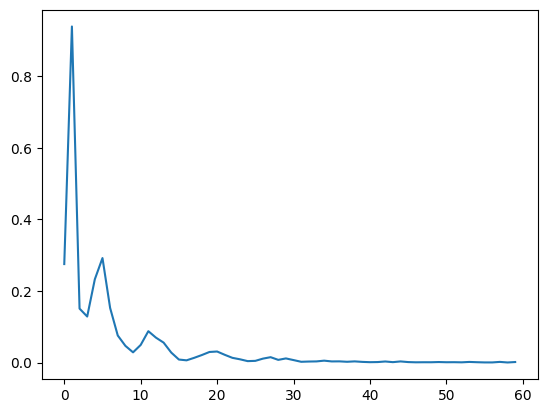

In [86]:
# plot loss over epochs
import matplotlib.pyplot as plt
plt.plot(loss_list)

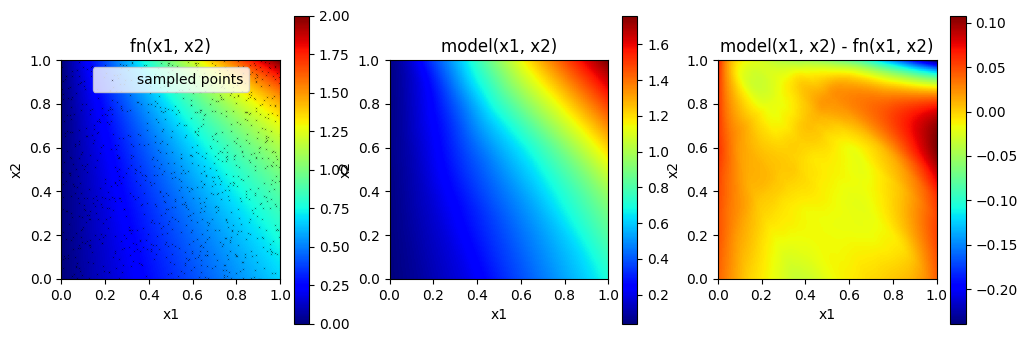

In [87]:
# plot fn(x1, x2) and model(x1, x2)
import numpy as np
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
Y_compressed = compressor_y(torch.Tensor(fn(X1,X2)).to('cuda').unsqueeze(-1)).squeeze(-1).cpu().detach().numpy()
Y_pred = model(torch.tensor(np.stack((X1, X2), axis=2), dtype=torch.float32, device='cuda')).cpu().detach().numpy()[..., 0]
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# plot heatmap
ax[0].imshow(Y_compressed, cmap='jet', extent=[0, 1, 0, 1])
ax[0].set_title('fn(x1, x2)')
ax[1].imshow(Y_pred, cmap='jet', extent=[0, 1, 0, 1])
ax[1].set_title('model(x1, x2)')
ax[2].imshow(Y_pred-Y_compressed, cmap='jet', extent=[0, 1, 0, 1])
ax[2].set_title('model(x1, x2) - fn(x1, x2)')
# scatter sampled points
ax[0].scatter(x[:,0].cpu().numpy(), x[:,1].cpu().numpy(), s=0.01, c='k', marker='x')
# label
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
ax[1].set_xlabel('x1')
ax[1].set_ylabel('x2')
ax[2].set_xlabel('x1')
ax[2].set_ylabel('x2')
# legend scatter points
ax[0].legend(['sampled points'])
# colorbar
fig.colorbar(ax[0].images[0], ax=ax[0])
fig.colorbar(ax[1].images[0], ax=ax[1])
fig.colorbar(ax[2].images[0], ax=ax[2])